In [1]:
from graph_tool.all import *
import graph_tool.all as gt
import numpy as np
import scipy as sp
from scipy.integrate import simpson
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from PyGnuplot import gp
import subprocess

In [2]:
Node = 10000

m = 2

times = 100

M_list  = [5, 10, 20, 50, 100, 200]

beta_list = [1,1/2,0,-1,-3,-5,-100]

net_list = ["SF", "Cutoff", "RA", "IPA_beta1", "IPA_beta3", "IPA_beta5", "IPA_beta100"]

In [3]:
from decimal import Decimal

w_list = [0.00, 0.50, 0.70, 0.90, 0.95, 0.98]

w_list = [Decimal(str(item)).quantize(Decimal('0.00')) for item in w_list]

In [4]:
def initial_degree_attack(g,Node):
    
    vertices = sorted([v for v in g.vertices()], key=lambda v: v.out_degree())
    sizes, comp = gt.vertex_percolation(g, vertices)
    degree_attack = [frc for frc in sizes]
    perc = np.array(degree_attack)
    perc = perc / Node
    
    return perc

# 第二固有値と固有ベクトルを算出する関数
def no_normalized_laplacian(g):
    # ラプラシアン行列の計算
    # `normalized` 引数を削除
    L = gt.laplacian(g)

    # scipyのスパース行列としてラプラシアン行列を取得
    L_sparse = sp.sparse.csr_matrix(L)

    # 固有値と固有ベクトルの計算 (第二小さい固有値とその固有ベクトルを求める)
    eigenvalues, eigenvectors = sp.sparse.linalg.eigsh(L_sparse, k=2, which='SM')

    second_values = eigenvalues[1]

    # フィードラーベクトル (第二小さい固有値に対応する固有ベクトル) の抽出
    fiedler_vector = eigenvectors[:, 1]

    return second_values, fiedler_vector

In [5]:
for M in tqdm(M_list):
    all_μ_list = []
    all_R_list = []
    for net in tqdm(net_list):
        L_net_list = []
        R_net_list = []
        for w in tqdm(w_list):
            ID = []
            L_list = []
            for i in range(times):
                g = load_graph(f"~/o_t_hayashilab/Network_data/graph-tool/modular_structure/{net}/w={w}/m0={M}/{i}.gt.gz")
                
                second_eigenvalue, fiedler_vector = no_normalized_laplacian(g)
                
                L_list.append(second_eigenvalue)
                
                perc = initial_degree_attack(g, Node)
                
                ID.append(perc)
            
            L_ave = np.mean(L_list)
            L_net_list.append(L_ave)
            ID_ave = np.mean(ID, axis=0)
            R = simpson(ID_ave, dx=1/Node)
            R_net_list.append(R)
            
        all_μ_list.append(L_net_list)
        all_R_list.append(R_net_list)
        
    # 保存先のディレクトリが存在しない場合は作成
    save_dir = f'~/o_t_hayashilab/modular_network_info/N={Node}/m0={M}/'
    os.makedirs(os.path.expanduser(save_dir), exist_ok=True)
    np.save(os.path.join(os.path.expanduser(save_dir), 'second_eigenvalue_list.npy'), np.array(all_μ_list))
    np.save(os.path.join(os.path.expanduser(save_dir), 'ID_R_list.npy'), np.array(all_R_list))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [02:31<12:37, 151.43s/it]

 33%|███▎      | 2/6 [05:40<11:34, 173.72s/it]

 50%|█████     | 3/6 [09:15<09:37, 192.51s/it]

 67%|██████▋   | 4/6 [13:04<06:53, 206.88s/it]

 83%|████████▎ | 5/6 [19:38<04:34, 274.31s/it]

100%|██████████| 6/6 [31:07<00:00, 311.17s/it]

 14%|█▍        | 1/7 [31:07<3:06:42, 1867.04s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [01:07<05:37, 67.45s/it]

 33%|███▎      | 2/6 [02:17<04:37, 69.26s/it]

 50%|█████     | 3/6 [03:29<03:31, 70.35s/it]

 67%|██████▋   | 4/6 [05:02<02:38, 79.08s/it]

 83%|████████▎ | 5/6 [07:13<01:38, 98.01s/it]

100%|██████████| 6/6 [10:06<00:00, 101.03s/it]

 29%|██▊       | 2/7 [41:13<1:33:46, 1125.38s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:50<04:11, 50.32s/it]

 33%|███▎      | 2/6 [01:39<03:17, 49.46s/it]

 50%|█████     | 3/6 [02:28<02:28, 49.44s/it]

 67%|██████▋   | 4/6 [03:36<01

In [5]:
from scipy.stats import pearsonr
# 単相関係数を計算して表示する関数
def calculate_and_display_correlation(x_values, y_values, label):
    correlation, _ = pearsonr(x_values, y_values)
    print(f"{label} の単相関係数: {correlation:.4f}")
    return correlation

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


v=1 の単相関係数: 0.7056
v=-3 の単相関係数: 0.6079
v=1/2 の単相関係数: 0.6962
v=-5 の単相関係数: 0.5699
v=0 の単相関係数: 0.6746
v=-100 の単相関係数: 0.5373
v=-1 の単相関係数: 0.6360


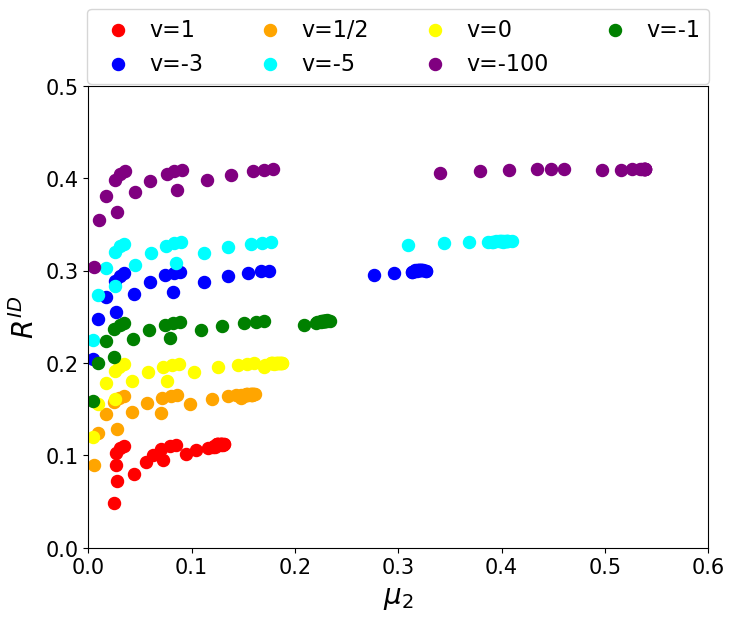

In [6]:
# 散布図を作成する関数（点線のプロットを除去）
def plot_correlation(x_values, y_values, label, color, marker='o', size=100):  # size引数を追加
    plt.scatter(x_values, y_values, label=label, color=color, marker=marker, s=size)

v1_R = []
v1_mu = []
v2_R = []
v2_mu = []
v3_R = []
v3_mu = []
v4_R = []
v4_mu = []
v5_R = []
v5_mu = []
v6_R = []
v6_mu = []
v7_R = []
v7_mu = []
    
for M in M_list:
    save_path = f"~/o_t_hayashilab/modular_network_info/N={Node}/m0={M}/ID_R_list.npy"
    ID_R_file = np.load(os.path.expanduser(save_path), allow_pickle=True)
    v1_R.append(ID_R_file[0])
    v2_R.append(ID_R_file[1])
    v3_R.append(ID_R_file[2])
    v4_R.append(ID_R_file[3])
    v5_R.append(ID_R_file[4])
    v6_R.append(ID_R_file[5])
    v7_R.append(ID_R_file[6])
    save_path = f"~/o_t_hayashilab/modular_network_info/N={Node}/m0={M}/second_eigenvalue_list.npy"
    μ_file = np.load(os.path.expanduser(save_path), allow_pickle=True)
    v1_mu.append(μ_file[0])
    v2_mu.append(μ_file[1])
    v3_mu.append(μ_file[2])
    v4_mu.append(μ_file[3])
    v5_mu.append(μ_file[4])
    v6_mu.append(μ_file[5])
    v7_mu.append(μ_file[6])

v1_R = np.array(v1_R).flatten()
v1_mu = np.array(v1_mu).flatten()
v2_R = np.array(v2_R).flatten()
v2_mu = np.array(v2_mu).flatten()
v3_R = np.array(v3_R).flatten()
v3_mu = np.array(v3_mu).flatten()
v4_R = np.array(v4_R).flatten()
v4_mu = np.array(v4_mu).flatten()
v5_R = np.array(v5_R).flatten()
v5_mu = np.array(v5_mu).flatten()
v6_R = np.array(v6_R).flatten()
v6_mu = np.array(v6_mu).flatten()
v7_R = np.array(v7_R).flatten()
v7_mu = np.array(v7_mu).flatten()
    
# 散布図を作成
plt.figure(figsize=(8, 6))

plot_correlation(v1_mu, v1_R, label='v=1', color='red', size=75)
correlation_v1 = calculate_and_display_correlation(v1_mu, v1_R, label='v=1')

plot_correlation(v5_mu, v5_R, label='v=-3', color='blue', size=75)
correlation_v2 = calculate_and_display_correlation(v5_mu, v5_R, label='v=-3')

plot_correlation(v2_mu, v2_R, label='v=1/2', color='orange', size=75)
correlation_v3 = calculate_and_display_correlation(v2_mu, v2_R, label='v=1/2')

plot_correlation(v6_mu, v6_R, label='v=-5', color='cyan', size=75)
correlation_v4 = calculate_and_display_correlation(v6_mu, v6_R, label='v=-5')

plot_correlation(v3_mu, v3_R, label='v=0', color='yellow', size=75)
correlation_v5 = calculate_and_display_correlation(v3_mu, v3_R, label='v=0')

plot_correlation(v7_mu, v7_R, label='v=-100', color='purple', size=75)
correlation_v6 = calculate_and_display_correlation(v7_mu, v7_R, label='v=-100')

plot_correlation(v4_mu, v4_R, label='v=-1', color='green', size=75)
correlation_v7 = calculate_and_display_correlation(v4_mu, v4_R, label='v=-1')

# 軸ラベルの設定
plt.xlabel(r"$μ_{2}$", fontsize=20)
plt.ylabel(r"$R^{ID}$", fontsize=20)

# x軸の範囲を設定（0から最大値+0.05）
plt.xlim(0, 0.6)
# x軸の目盛りを調整（ここでは0.1刻みに設定し、フォントサイズを15に）
plt.xticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=15)

# y軸の範囲を設定（0から最大値+0.05）
plt.ylim(0, 0.5)
plt.yticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=15)

# 凡例の設定（上に2×2で配置）
plt.legend(loc='upper center', fontsize=16, bbox_to_anchor=(0.5, 1.19), ncol=4, handletextpad=0.4)

# 保存先のディレクトリを指定
save_dir = os.path.expanduser('~/o_t_hayashilab/modular_network_info/μ_R_correlation/')
os.makedirs(save_dir, exist_ok=True)  # ディレクトリが存在しない場合は作成
# EPS形式で図を保存（フルパスを指定）
save_path = os.path.join(save_dir, f"R^ID_mu2.eps")
plt.savefig(save_path, format='eps', bbox_inches='tight')

# プロットの表示
plt.show()

In [7]:
mu_all = np.concatenate([v1_mu, v2_mu, v3_mu, v4_mu, v5_mu, v6_mu, v7_mu])
R_all = np.concatenate([v1_R, v2_R, v3_R, v4_R, v5_R, v6_R, v7_R])

# 全データの相関係数を計算
overall_correlation = np.corrcoef(mu_all, R_all)[0, 1]  # 相関係数マトリックスから[0,1]成分を取得

# 全体の相関係数を表示
print(f"全データの相関係数: {overall_correlation:.3f}")

全データの相関係数: 0.536


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


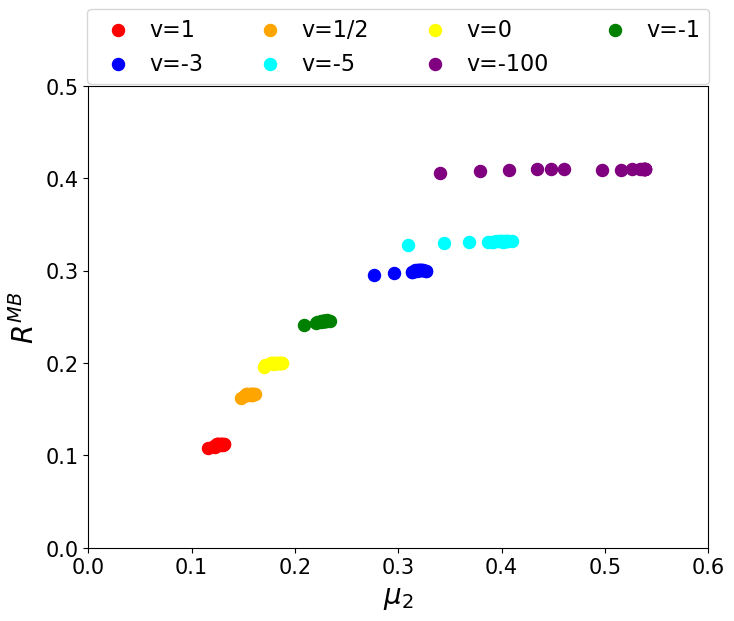

Overall correlation: 0.9627675304949961


In [8]:
# 抽出するインデックスリスト
indices = [0, 1, 2, 6, 7, 8, 12, 13, 14, 18, 19, 20, 24, 25, 26, 30, 31, 32]

# 抽出して新しいリストに格納
v1_R_selected = v1_R[indices]
v1_mu_selected = v1_mu[indices]
v2_R_selected = v2_R[indices]
v2_mu_selected = v2_mu[indices]
v3_R_selected = v3_R[indices]
v3_mu_selected = v3_mu[indices]
v4_R_selected = v4_R[indices]
v4_mu_selected = v4_mu[indices]
v5_R_selected = v5_R[indices]
v5_mu_selected = v5_mu[indices]
v6_R_selected = v6_R[indices]
v6_mu_selected = v6_mu[indices]
v7_R_selected = v7_R[indices]
v7_mu_selected = v7_mu[indices]

# 新しい散布図を作成
plt.figure(figsize=(8, 6))

# リスト1のプロット
plot_correlation(v1_mu_selected, v1_R_selected, label='v=1', color='red', size=75)
plot_correlation(v5_mu_selected, v5_R_selected, label='v=-3', color='blue', size=75)
plot_correlation(v2_mu_selected, v2_R_selected, label='v=1/2', color='orange', size=75)
plot_correlation(v6_mu_selected, v6_R_selected, label='v=-5', color='cyan', size=75)
plot_correlation(v3_mu_selected, v3_R_selected, label='v=0', color='yellow', size=75)
plot_correlation(v7_mu_selected, v7_R_selected, label='v=-100', color='purple', size=75)
plot_correlation(v4_mu_selected, v4_R_selected, label='v=-1', color='green', size=75)

# 軸ラベルの設定
plt.xlabel(r"$μ_{2}$", fontsize=20)
plt.ylabel(r"$R^{MB}$", fontsize=20)

# x軸とy軸の範囲設定
plt.xlim(0, 0.6)
plt.xticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=15)
plt.ylim(0, 0.5)
plt.yticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=15)

# 凡例の設定
plt.legend(loc='upper center', fontsize=16, bbox_to_anchor=(0.5, 1.19), ncol=4, handletextpad=0.4)

# EPS形式で保存
save_path = os.path.join(save_dir, f"R^MB_mu2_selected.eps")
plt.savefig(save_path, format='eps', bbox_inches='tight')

# プロットの表示
plt.show()

# すべてのデータを結合
all_mu = np.concatenate([v1_mu_selected, v2_mu_selected, v3_mu_selected, v4_mu_selected, v5_mu_selected, v6_mu_selected, v7_mu_selected])
all_R = np.concatenate([v1_R_selected, v2_R_selected, v3_R_selected, v4_R_selected, v5_R_selected, v6_R_selected, v7_R_selected])

# 全体の相関係数を計算
overall_corr = np.corrcoef(all_mu, all_R)[0, 1]

# 結果を表示
print(f"Overall correlation: {overall_corr}")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


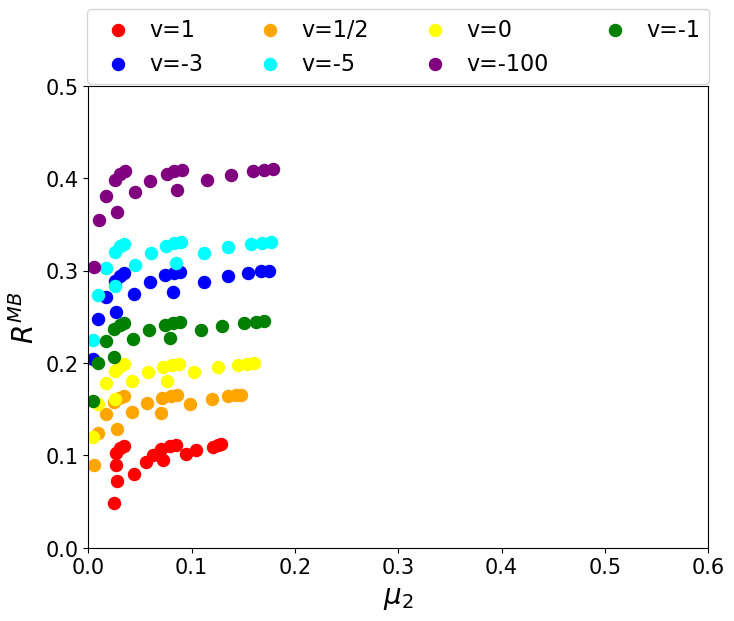

Overall correlation: 0.19791513766051907


In [9]:
# 選択されなかったインデックスを取得
all_indices = np.arange(len(v1_R))  # 元の配列のインデックス全体
unselected_indices = np.delete(all_indices, indices)  # 選択されなかったインデックスを取得

# 抽出して新しいリストに格納（未選択の要素）
v1_R_unselected = v1_R[unselected_indices]
v1_mu_unselected = v1_mu[unselected_indices]
v2_R_unselected = v2_R[unselected_indices]
v2_mu_unselected = v2_mu[unselected_indices]
v3_R_unselected = v3_R[unselected_indices]
v3_mu_unselected = v3_mu[unselected_indices]
v4_R_unselected = v4_R[unselected_indices]
v4_mu_unselected = v4_mu[unselected_indices]
v5_R_unselected = v5_R[unselected_indices]
v5_mu_unselected = v5_mu[unselected_indices]
v6_R_unselected = v6_R[unselected_indices]
v6_mu_unselected = v6_mu[unselected_indices]
v7_R_unselected = v7_R[unselected_indices]
v7_mu_unselected = v7_mu[unselected_indices]

# 新しい散布図を作成（未選択要素のプロット）
plt.figure(figsize=(8, 6))

# リスト1のプロット
plot_correlation(v1_mu_unselected, v1_R_unselected, label='v=1', color='red', size=75)
plot_correlation(v5_mu_unselected, v5_R_unselected, label='v=-3', color='blue', size=75)
plot_correlation(v2_mu_unselected, v2_R_unselected, label='v=1/2', color='orange', size=75)
plot_correlation(v6_mu_unselected, v6_R_unselected, label='v=-5', color='cyan', size=75)
plot_correlation(v3_mu_unselected, v3_R_unselected, label='v=0', color='yellow', size=75)
plot_correlation(v7_mu_unselected, v7_R_unselected, label='v=-100', color='purple', size=75)
plot_correlation(v4_mu_unselected, v4_R_unselected, label='v=-1', color='green', size=75)

# 軸ラベルの設定
plt.xlabel(r"$μ_{2}$", fontsize=20)
plt.ylabel(r"$R^{MB}$", fontsize=20)

# x軸とy軸の範囲設定
plt.xlim(0, 0.6)
plt.xticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=15)
plt.ylim(0, 0.5)
plt.yticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=15)

# 凡例の設定
plt.legend(loc='upper center', fontsize=16, bbox_to_anchor=(0.5, 1.19), ncol=4, handletextpad=0.4)

# EPS形式で保存
save_path = os.path.join(save_dir, f"R^MB_mu2_unselected.eps")
plt.savefig(save_path, format='eps', bbox_inches='tight')

# プロットの表示
plt.show()

# すべてのデータを結合
all_mu = np.concatenate([v1_mu_unselected, v2_mu_unselected, v3_mu_unselected, v4_mu_unselected, v5_mu_unselected, v6_mu_unselected, v7_mu_unselected])
all_R = np.concatenate([v1_R_unselected, v2_R_unselected, v3_R_unselected, v4_R_unselected, v5_R_unselected, v6_R_unselected, v7_R_unselected])

# 全体の相関係数を計算
overall_corr = np.corrcoef(all_mu, all_R)[0, 1]

# 結果を表示
print(f"Overall correlation: {overall_corr}")